# UMAP analysis for seismic coda waves



In [1]:
import os
import sys

os.chdir("/bettik/dokhtdor/projects/mirko_volcano_simulations/")

import numpy as np
import scipy as sp

from tqdm import tqdm
#from matplotlib import colors

import matplotlib.pyplot as plt
import proplot as pplt

from scatseisnet import ScatteringNetwork
from maincodes.sc_loader import *
from maincodes.umap_analysis import *

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import umap


In [ ]:
freqmax = 8
sr = 40
reduce_type = np.mean

name_fig = 'FIGURES_UMAP_SPACE'

FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name_fig}/"
os.makedirs(savepath, exist_ok=True)


In [3]:

vs_hr = np.load(FILEPATH+'vs_map_2400x1300.npy')
vs_hr = vs_hr/1000

vs = np.load(FILEPATH+'vs_array.npy') 
vs = vs/1000

data_records_vs = []
data_records_hs = []


for i in range(1, 6):

    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/z_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/z_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_vs.append(data_read)

    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/x_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/x_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_hs.append(data_read)


data_records_vs = np.array(data_records_vs) 
data_records_hs = np.array(data_records_hs)

data_records_vs = apply_sosfilter(data_records_vs[:,:,:],freq = freqmax, sr = sr, filter_type = 'lp')
data_records_vs = np.concatenate(data_records_vs, axis = 1)

data_records_hs = apply_sosfilter(data_records_hs[:,:,:], freq = freqmax, sr = sr, filter_type = 'lp')
data_records_hs = np.concatenate(data_records_hs, axis = 1)



In [4]:

x_dist = (10000+100*np.arange(65))/1000
y_dist = (2500+100*np.arange(120))/1000

y_dist.min(), y_dist.max()

time_ = np.arange(0, data_records_hs.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]

x_dist_hr = np.arange(10, 16.5, .005)
y_dist_hr = np.arange(2.5, 14.5, .005)



In [5]:

segment_duration_seconds = data_records_hs.shape[-1]/sr
sampling_rate_hertz = sr
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)

bank_keyword_arguments = (
        {"octaves": 4, "resolution": 8, "quality": 2, "normalize_wavelet": 'l2'},
        {"octaves": 5, "resolution": 5, "quality": 2, "normalize_wavelet": 'l2'},
        )


network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
ComplexMorletBank(bins=1500, octaves=5, resolution=5, quality=2, sampling_rate=40, len=25)


/tmp/ipykernel_267624/1417108473.py:35: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.1

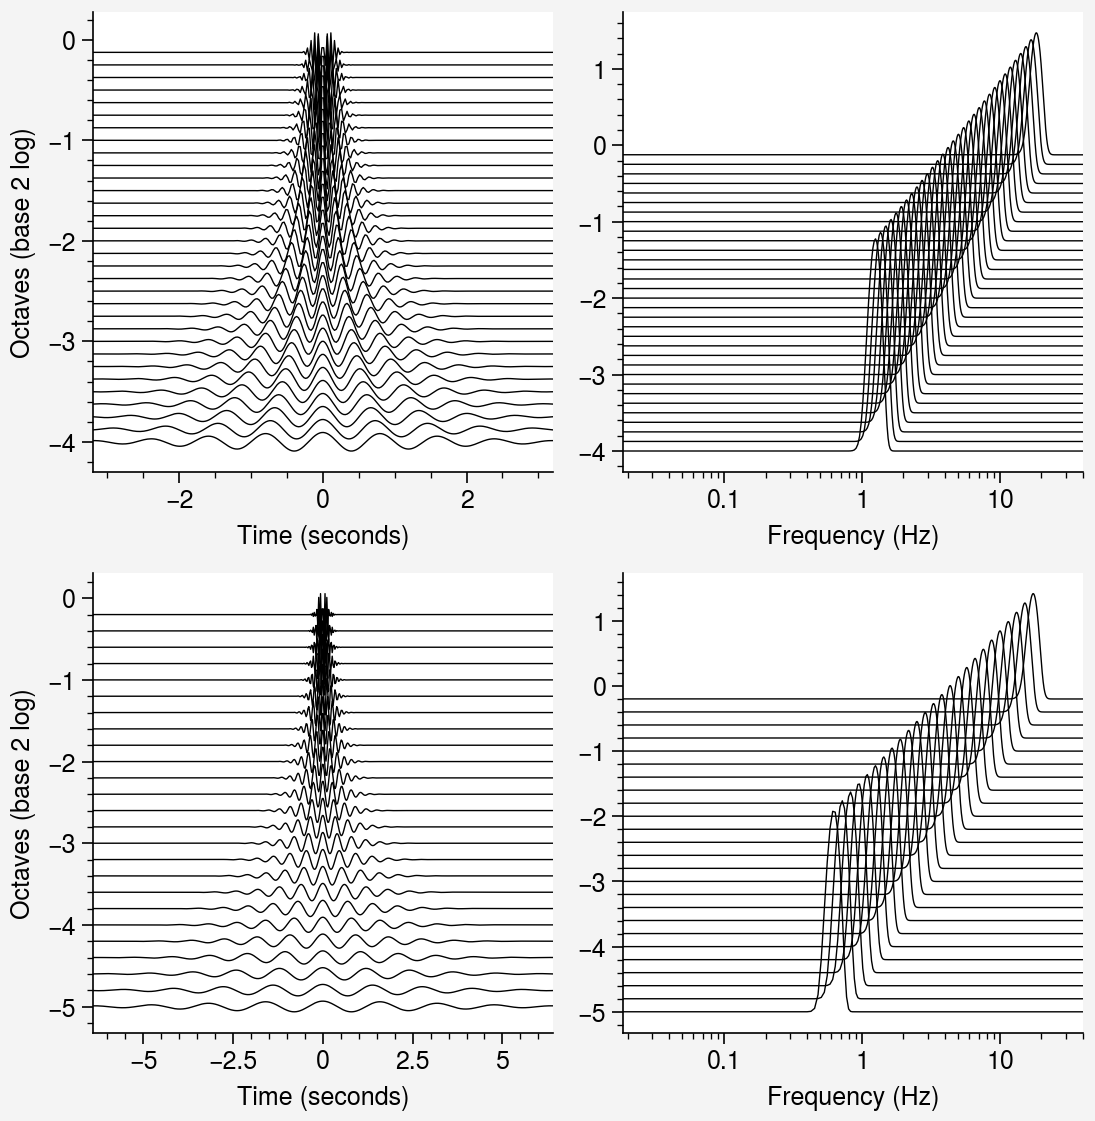

In [6]:
fig = pplt.figure(refwidth=2.3, share=False)
ax = fig.subplots(ncols=2, nrows=2)


for i, bank in enumerate(network.banks):
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
        ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)

    width_max = 2 * bank.widths.max()
    # Labels
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()
    

for axn in ax:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    
fig.tight_layout()
#fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)



In [7]:
segments = [data_records_hs[i,:,:] for i in indxvs[indx, 30]]

sc1 = network.transform(segments,  reduce_type= None )


In [8]:

sc_med__vs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_vs_4_median_40.npz"
sc_med__hs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_hs_4_median_40.npz"


scattering_coeff_vs = reader_coeff(sc_med__vs, network = network)
scattering_coeff_hs = reader_coeff(sc_med__hs, network = network)


In [9]:

scaler1 = [MinMaxScaler(feature_range = (-1, 1)), MinMaxScaler(feature_range = (-1, 1))]
scaler2 = [MinMaxScaler(feature_range = (-1, 1)), MinMaxScaler(feature_range = (-1, 1))]

#scaler = [RobustScaler(), RobustScaler()]

scattering_coef_vs_norm = preprocessing_(scattering_coeff_vs, scaler = scaler1)
scattering_coef_hs_norm = preprocessing_(scattering_coeff_hs, scaler = scaler2)


Normalization applied
Normalization applied


In [10]:

UMAP_model = []
UMAP_space = []

for i, coeff_ in enumerate([scattering_coef_vs_norm, scattering_coef_hs_norm]):
    model_umap = umap.UMAP(
        n_neighbors = 40,
        min_dist = 0.0,
        n_components = 2,
        random_state = 42,
        metric = 'manhattan',
        #local_connectivity = 20
        )
    
    UMAP_space.append(model_umap.fit_transform(coeff_[:,320:]))
    UMAP_model.append(model_umap)
    
    print(f'UMAP {i} done')
    
    

/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP 0 done


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP 1 done


/tmp/ipykernel_267624/1640146390.py:11: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 0.9216814, 'vmax': 3.5157309}
  im = ax[i].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k',
/tmp/ipykernel_267624/1640146390.py:11: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 0.9216814, 'vmax': 3.5157309}
  im = ax[i].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k',
/tmp/ipykernel_267624/1640146390.py:48: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(

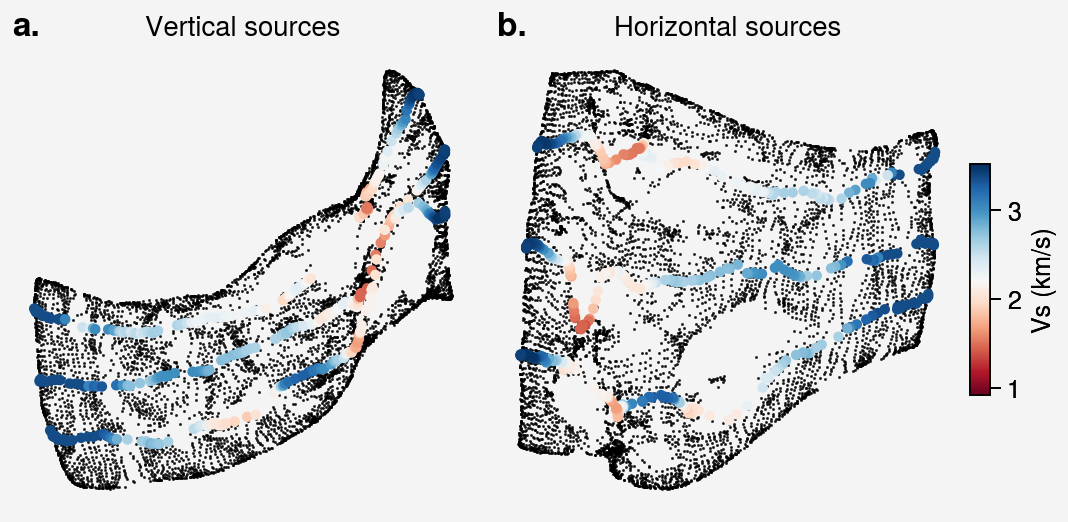

In [11]:
fig = pplt.figure(refwidth=2.3, share=False)
ax = fig.subplots(ncols=2, nrows=1)

tit = ['station R3', 'combined-seismograms']
tit_ind = ['a', 'd']

vs_plotindex = [15, 30, 45]

for i, umap_data in enumerate(UMAP_space):

    im = ax[i].scatter(umap_data[:, 0], umap_data[:, 1], c = 'k', 
                        vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                        s = 0.25, alpha = 0.75, rasterized=True)
    
    for j in vs_plotindex:
        if j == 45 and i == 1:
                
            im = ax[i].scatter(umap_data[indxvs[:, j], 0], umap_data[indxvs[:, j], 1], c = vs.reshape(-1)[indxvs[:, j]],
                                vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                                cmap = 'RdBu', s = 10, alpha = 1, rasterized=True, colorbar = 'r', colorbar_kw={'label':'Vs (km/s)', 'width':0.1, 'length':0.5})
        else:
            im = ax[i].scatter(umap_data[indxvs[:, j], 0], umap_data[indxvs[:, j], 1], c = vs.reshape(-1)[indxvs[:, j]],
                                vmin =vs.reshape(-1).min(), vmax = vs.reshape(-1).max(),
                                cmap = 'RdBu', s = 10, alpha = 1, rasterized=True)
    ax[i].axis("off")


    # axins1 = inset_axes(ax[1], width="2.5%", height="30%", loc="lower right",)
    # axins1.xaxis.set_ticks_position("bottom")
    #fig.colorbar(im, cax=axins1, orientation="vertical", label = 'Vs (km/s)')
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    ax[i].set_xlabel('UMAP variable 1')
    #ax[i].axis("off")
    
ax[0].set_ylabel('UMAP variable 2')

[ax[i].set_title(f) for i, f in enumerate(['Vertical sources', 'Horizontal sources'])]


tit_ind = ['a', 'b', 'c', 'd', 'e', 'f']
for i in range(2):
    ax[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

    
fig.tight_layout()
fig.savefig(savepath + "UMAP_atlas_2" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [12]:
LOC_DIM = []

for i , umodel in enumerate(UMAP_model):
    
    print(f'UMAP for data {i}')
    LOC_DIM.append(calculate_local_dimension(umodel, threshold = 0.6))
    

UMAP for data 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [02:01<00:00, 64.19it/s]


UMAP for data 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [02:08<00:00, 60.51it/s]


/tmp/ipykernel_267624/3372131029.py:18: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 5, 'vmax': 16}
  im1 = ax[i+1].imshow(loc_dim.reshape(120, 65),
/tmp/ipykernel_267624/3372131029.py:18: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 4, 'vmax': 16}
  im1 = ax[i+1].imshow(loc_dim.reshape(120, 65),
/tmp/ipykernel_267624/3372131029.py:41: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tr

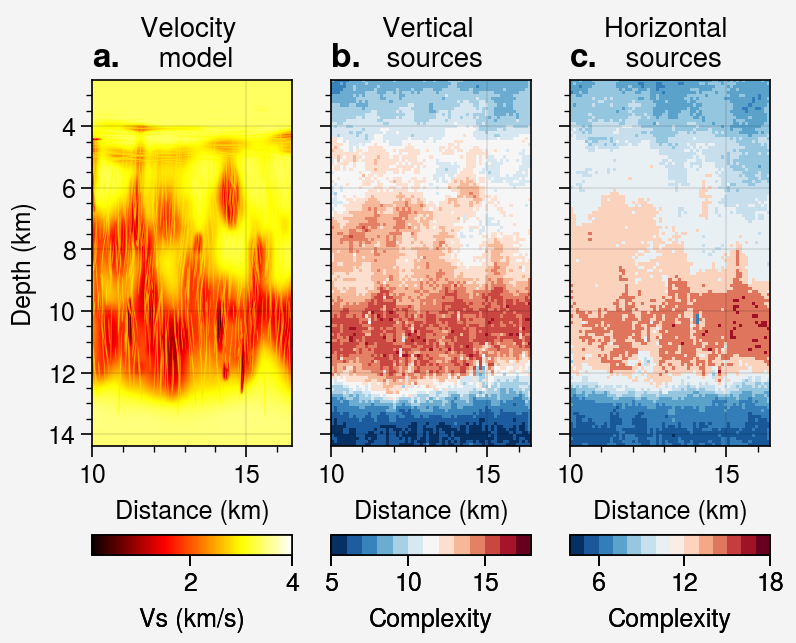

In [13]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
ax = fig.subplots(ncols=3, nrows=1)

im1 = ax[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, colorbar = 'b', colorbar_kw={'label':'Vs (km/s)', 'width':0.1})


ax[0].set_ylim(y_dist.max(), y_dist.min())
ax[0].set_ylabel('Depth (km)')
ax[0].set_xlabel('Distance (km)')


for i, loc_dim in enumerate(LOC_DIM):
    levels = pplt.arange(np.min(loc_dim), np.max(loc_dim)+2, 1)

    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = ax[i+1].imshow(loc_dim.reshape(120, 65), 
                        cmap = 'RdBu_r', 
                        vmin = loc_dim.min(), 
                        vmax = loc_dim.max(), 
                        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
                        aspect = 'auto', 
                        rasterized = True,
                        colorbar = 'b',
                        colorbar_kw={'label':'Complexity', 'width':0.1},
                        levels=levels)

    ax[i+1].set_ylim(y_dist.max(), y_dist.min())
    ax[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    ax[i+1].set_xlabel('Distance (km)')
    #cbar.set_label('Complexity index')

for i in range(len(ax)):
    ax[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

[ax[i].set_title(f) for i, f in enumerate(['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources'])]

fig.tight_layout()
fig.savefig(savepath + "UMAP_LOCAL_DIMENSIONALITY" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



In [14]:

def fft_(data, n):    
    nn = n//2
    return np.abs(np.fft.fft(data, n = n))[...,:nn], np.arange(nn)/(2*nn)


titl = ['a', 'b', 'c', 'd', 'e', 'f', 'g']




/tmp/ipykernel_267624/3155675728.py:4: ProplotWarning: 'gridspec_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  ax = fig.subplots(ncols=3, nrows=2, gridspec_kw=gs)


/tmp/ipykernel_267624/3155675728.py:60: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3

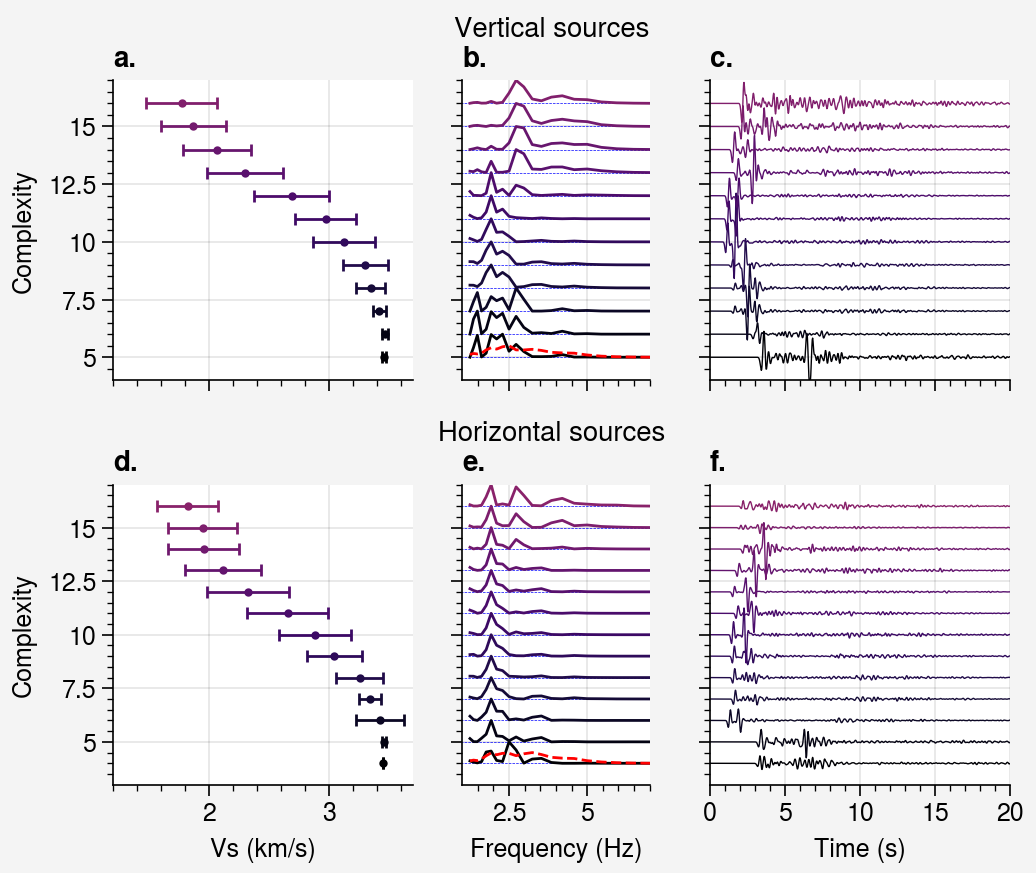

In [15]:
fig = pplt.figure(refwidth=1.5, sharey=True, sharex=True, span=False)

gs = {"width_ratios": [4,  2.5, 4]}
ax = fig.subplots(ncols=3, nrows=2, gridspec_kw=gs)


for i, d, sc, data_records in zip(range(2),[LOC_DIM[0], LOC_DIM[1]], [scattering_coeff_vs, scattering_coeff_hs], [data_records_vs, data_records_hs]):
    locdim = d
    dim = np.unique(locdim[::1])
    
    cmap = plt.get_cmap('inferno', len(dim)+20)

    for j, dimen in enumerate(dim[::1]):
        indx = locdim == dimen
        vsselected = vs.reshape(-1)[indx]
        depth = np.repeat(y_dist, 65)[indx]

        dd = data_records[np.where(indx)[0]][:, :, :]
        dd = dd[0, 4]/ np.max(abs(dd[0, 5]))/1.1
        
        bplot = ax[i, 0].errorbar(np.mean(vsselected), dimen, xerr = np.std(vsselected), fmt = 'o', lw =1 , markersize = 2, capsize = 2, capthick = 1, c = cmap(j))
        ax[i, 0].set_xlim(1.2, 3.7)
        plo = np.mean(sc[0][:, :4:5,:], 0)
        sc_selected = np.mean(np.mean(sc[0][np.where(indx)[0]][:, 4:5,:] - plo, axis =0), axis = 0)
        sc_selected = (sc_selected)**2
        sc_selected = sc_selected / np.max(abs(sc_selected))
        plo2 = np.mean(plo, 0)**2
        plo2 = plo2 /np.max(plo2)/2
        ax[i, 1].plot(network.banks[0].centers, 1*(sc_selected) + dimen,  lw = 1 , c = cmap(j))
        if j == 0:
              ax[i, 1].plot(network.banks[0].centers, plo2 + dimen,  lw = 1 , c = 'r', linestyle = '--')

        ax[i, 1].hlines(dimen,0, network.banks[0].centers.max(), lw = 0.25, linestyle = '--', color = 'b')

        ax[i, 1].set_xlim(1, 7)

        ax[i, 2].plot(time_, dd + dimen, c = cmap(j), lw = 0.5)

    ax[i, 0].set_ylim(dim[0]-1, dim[-1]+1) 
    ax[i, 1].set_ylim(dim[0]-1, dim[-1]+1) 
    ax[i, 2].set_ylim(dim[0]-1, dim[-1]+1) 
    ax[i, 2].set_xlim(0., 20)

    ax[i, 0].set_ylabel('Complexity')
ax[1, 0].set_xlabel('Vs (km/s)')
ax[1, 1].set_xlabel('Frequency (Hz)')
ax[1, 2].set_xlabel('Time (s)')


for i in range(len(ax)):
    ax[i].set_title(titl[i]+'.', loc = 'left', fontsize = 10, fontweight = 'bold')

ax[0, 1].set_title('Vertical sources \n')
ax[1, 1].set_title('Horizontal sources \n')

for axn in ax:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    
fig.tight_layout()
fig.savefig(savepath + "local_dimensionality_in_waveform" + ".png", bbox_inches="tight", dpi=300, transparent=True, )


In [16]:

# inv_umap = UMAP_model[0].inverse_transform(UMAP_space[0][indxvs[:, 30],:])


In [17]:
# dd22_2 = scaler1[1].inverse_transform(inv_umap[:, :])

# dd22_2=(dd22_2.reshape(120, 10, 32, 20))
# ss = 2**dd22_2[:, 3, :,:]
# ss[ss>0.9] = np.nan

# scattering_coeff_vs[1].shape


/tmp/ipykernel_267624/3990327316.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_267624/3990327316.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)


/tmp/ipykernel_267624/3990327316.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_267624/3990327316.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_267624/3990327316.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_267624/3990327316.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_267624/3990327316.py:83: ProplotWarning: Got conflicting or duplicate keyword args: {'length': 0.5, 'shrink': 0.4}. Using the first one.
  fig.colorbar(im,
/tmp/ipykernel_267624/3990327316.py:91: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_trem

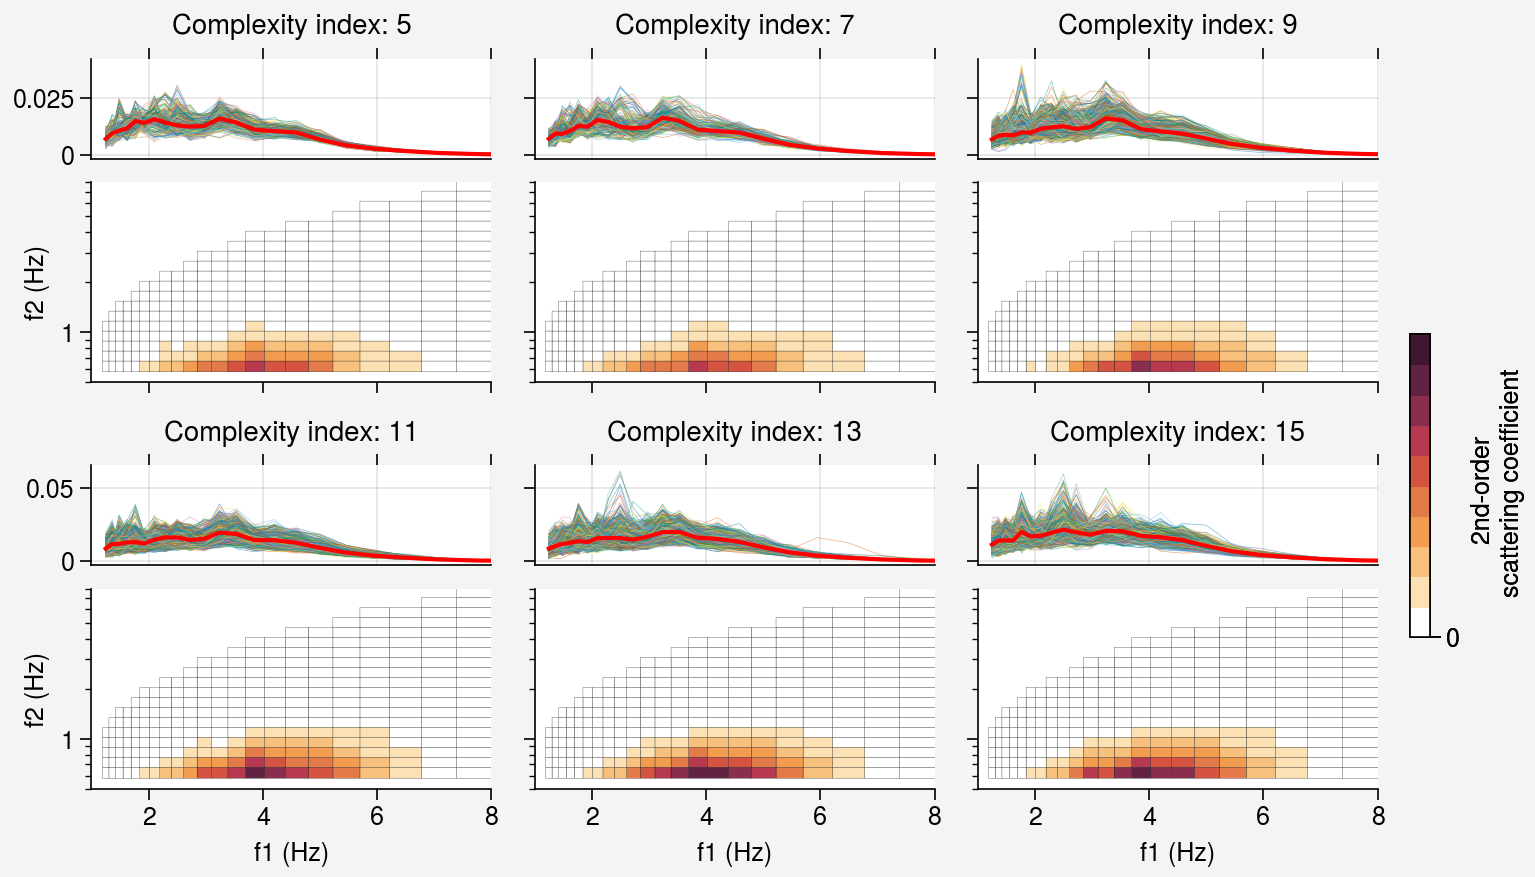

In [18]:

scc = scattering_coeff_vs[1][:, 5,:,:]
scc0 = scattering_coeff_vs[0][:,5,:]
#scc = np.nanmean(scc, axis = 1)
#scc0 = np.nanmean(scc0, axis = 1)


fig = pplt.figure( refwidth=2, refheight=1, sharex=True, sharey=True, span=False)
gs = {"height_ratios": [1, 1, 1]}
axs=fig.subplots(ncols=3, nrows=2, )

ii = 0
loc_index=np.unique(LOC_DIM[0])[::2]

for i, loc_d_val in enumerate(loc_index):
    index = np.where(LOC_DIM[0]==loc_d_val)[0]
    sc_sel=abs(scc[index][:,...])
    
    sc_sel=sc_sel#-np.nanmean(scc, axis = 0, keepdims = True)  
    sc_sel=np.nanmean(sc_sel, axis = 0)
    
    im=axs[ii].pcolor(network.banks[0].centers, 
                   network.banks[1].centers, 
                   sc_sel.T,
                   rasterized=True, 
                   edgecolors='k', 
                   linewidths=0.1,
                   vmin=0,
                   vmax=0.04,
                   )
    
    axs[ii].set_yscale('log')
    #axs[ii].set_xscale('log')

    #axs[ii].axis('off')
    axs[ii].set_xlim(1, 8)
    axs[ii].set_ylim(0.5, 8)
    axs[ii].set_title(f'Complexity index: {loc_d_val}')


    pax = axs[ii].panel_axes('t')
    
    sc_sel_=scc0[index]
    sc_sel=sc_sel_[:,...]#-np.nanmean(scc, axis = 0, keepdims = True)  
    sc_sel=np.nanmedian(sc_sel, axis = 0)
        
    pax.plot(network.banks[0].centers,
             sc_sel_.T, 
             lw = 0.25, 
             alpha =0.5,
             rasterized=True,
             )
    
    pax.plot(network.banks[0].centers,
             sc_sel, 
             rasterized=True,
             c='r',
             
             )
            
    #pax.set_ylim(0, 0.02)
    pax.set_xlim(1, 8)

    pax.spines['top'].set_visible(False)
    pax.spines['right'].set_visible(False)
    
    pax.minorticks_off()

    
    ii+=1
    
    
for axn in axs:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    axn.set_xlim(1, 8)
    
axs[0].set_ylabel('f2 (Hz)')
axs[3].set_ylabel('f2 (Hz)')
axs[-1].set_xlabel('f1 (Hz)')
axs[-2].set_xlabel('f1 (Hz)')
axs[-3].set_xlabel('f1 (Hz)')

fig.colorbar(im, 
             width=0.1,
             shrink=0.4,
             length =0.5, 
             label='2nd-order \n scattering coefficient', 
             locator = 5)


fig.tight_layout()
fig.savefig(savepath + "second_order"+".png", bbox_inches="tight", dpi=300, transparent=True, )


In [19]:
corr_length_data = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/data_processed/corr_length.npy')
std_mean_ = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/data_processed/std_mean_500m.npy')
corr_smooth = sp.ndimage.gaussian_filter(corr_length_data, 0.8)


/tmp/ipykernel_267624/888599001.py:4: ProplotWarning: 'gridspec_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  ax = fig.subplots(ncols=2, nrows=2, gridspec_kw=gs)
/tmp/ipykernel_267624/888599001.py:53: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword a

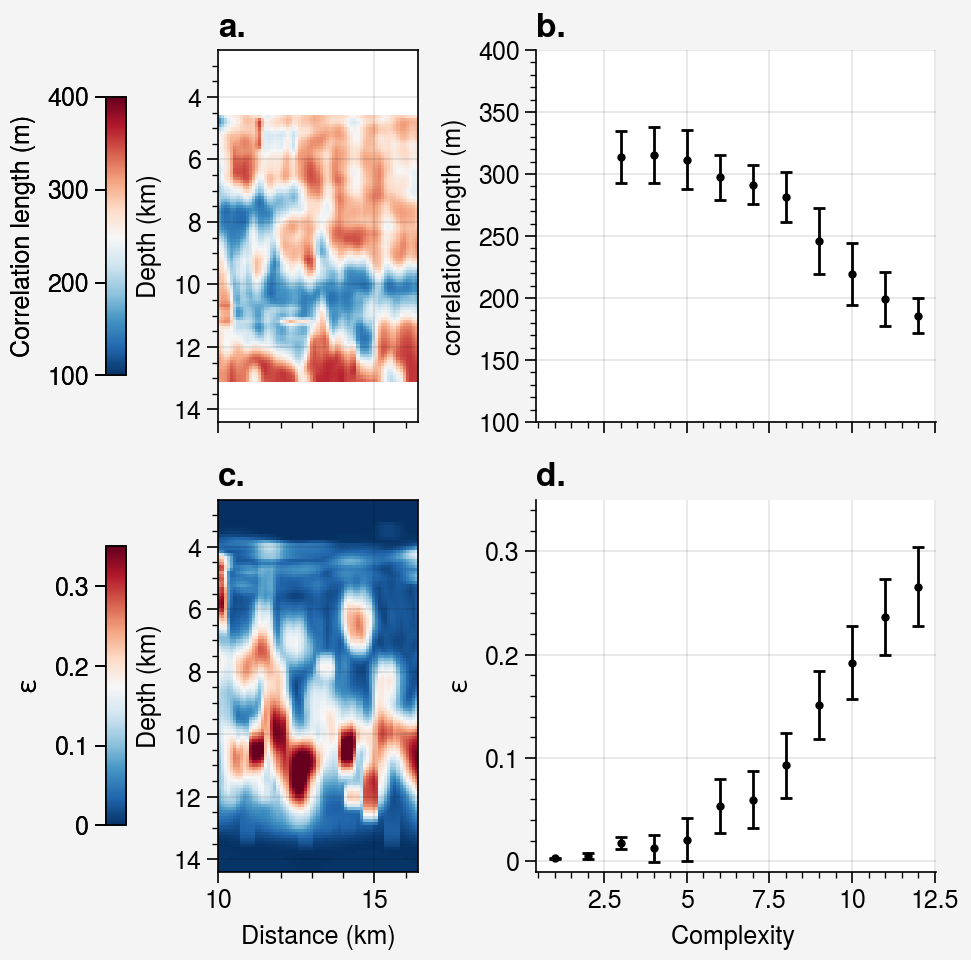

In [20]:
fig = pplt.figure( sharey=False, sharex=True, refwidth=1, span=False)

gs = {"width_ratios": [0.5, 1]}
ax = fig.subplots(ncols=2, nrows=2, gridspec_kw=gs)

locdim = LOC_DIM[0]
dim = np.unique(LOC_DIM[0])
cmaaps = ['RdBu_r', 'RdBu_r']

for i, par, title, cvalues in zip([0, 2], [corr_smooth, std_mean_], ['Correlation length (m)', '$\epsilon$'], [[100, 400], [0,0.35]]):
    #im1 = ax[i].pcolor(x_dist, y_dist, par, cmap = 'RdBu_r', edgecolors='k', linewidths=0.01, rasterized = True, vmin = cvalues[0], vmax = cvalues[1])
    im1 = ax[i].imshow(par, cmap = cmaaps[0], 
    extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], 
    rasterized = True, vmin = cvalues[0], vmax = cvalues[1], colorbar = 'l', colorbar_kw={'width':0.1,  'label': title, 'length': 0.75})

    for j, dimen in enumerate(dim[::1]):

        qw = par.reshape(-1)[np.where(locdim==dimen)[0]]
        depth = np.repeat(y_dist, 65)[np.where(locdim==dimen)[0]]
        depth = depth[~np.isnan(qw)]
        qw = qw[~np.isnan(qw)]
        
        if len(qw) > 5:
            #bplot = ax[i].boxplot(qw, 0, 'rs', 0.,  positions=[j+1], widths = 0.4, patch_artist = True, showfliers = False, medianprops=dict(color="k"))
            bplot = ax[i+1].errorbar(j+1, np.mean(qw), yerr = np.std(qw)/2, fmt = 'o', lw =1, markersize = 2, capsize = 2, capthick = 1, c = 'k', rasterized = True)


ax[0, 0].set_ylabel('Depth (km)')
ax[1, 0].set_ylabel('Depth (km)')
ax[1, 0].set_xlabel('Distance (km)')


ax[0, 1].set_ylim(100, 400)
ax[1, 1].set_ylim(-0.01, 0.35)

#axs[1, 0].set_xlabel('Complexity index')
ax[0, 1].set_ylabel('correlation length (m)')

ax[0, 1].set_xlabel('Complexity ')
ax[1, 1].set_xlabel('Complexity ')

ax[1, 1].set_ylabel('$\epsilon$')


for axn in ax[:,1]:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)


for i in range(4):
    ax[i].set_title(f'{titl[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

fig.tight_layout()
fig.savefig(savepath + "correlation_length_vs_local_dim_all" + ".png", bbox_inches="tight", dpi=300, transparent=True, )



In [25]:
LOC_DIM[0]

array([8, 7, 7, ..., 6, 6, 6])

/tmp/ipykernel_267624/3218973277.py:38: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3

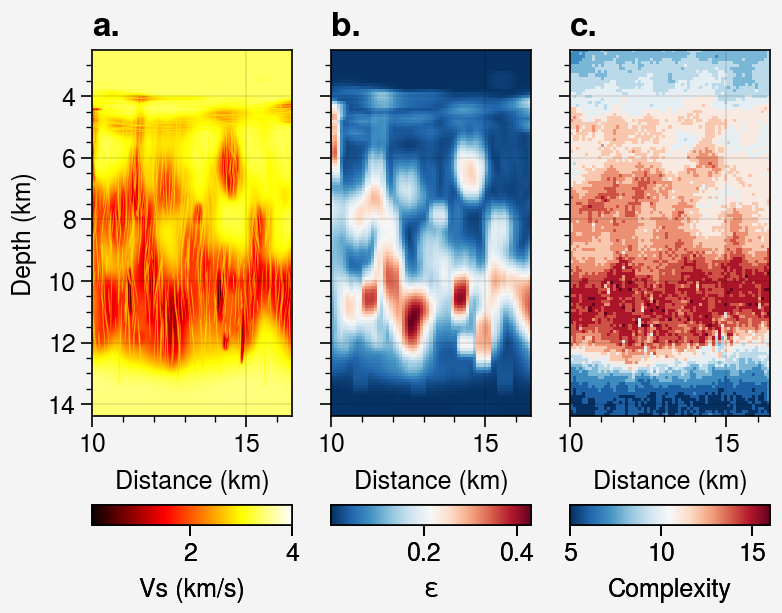

In [31]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
ax = fig.subplots(ncols=3, nrows=1)

im1 = ax[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, colorbar = 'b', colorbar_kw={'label':'Vs (km/s)', 'width':0.1})
ax[0].set_ylim(y_dist.max(), y_dist.min())
ax[0].set_ylabel('Depth (km)')
ax[0].set_xlabel('Distance (km)')


im1 = ax[1].imshow(std_mean_, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'RdBu_r',
                       rasterized = True, colorbar = 'b', colorbar_kw={'label':'$\epsilon$', 'width':0.1})
ax[1].set_ylim(y_dist.max(), y_dist.min())
ax[1].set_xlabel('Distance (km)')

loc_dim = LOC_DIM[0]

im1 = ax[2].imshow(loc_dim.reshape(120, 65), 
                        cmap = 'RdBu_r', 
                        vmin = loc_dim.min(), 
                        vmax = loc_dim.max(), 
                        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
                        aspect = 'auto', 
                        rasterized = True,
                        colorbar = 'b',
                        colorbar_kw={'label':'Complexity', 'width':0.1},)


for i in range(3):
    ax[i].set_title(f'{titl[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

ax[2].set_ylim(y_dist.max(), y_dist.min())
ax[2].set_xlabel('Distance (km)')


fig.tight_layout()
fig.savefig(savepath + "figure_for_abstract" + ".png", bbox_inches="tight", dpi=300, transparent=True, )



In [ ]:

UMAPS_MODEL_HYPERPAR = []
UMAP_SPACE_HYPERPAR = []

k_neighbors = [10 , 30, 50, ]
min_distances = [0.1, 0.5, 0.9]

# Loop over hyperparameters
for i, neighbor in enumerate(k_neighbors):
    print(f'UMAP for data {i}')
    model_u = []
    space_u = []

    # Loop over hyperparameters
    for j, mindis in enumerate(min_distances):
        umodel = umap.UMAP(densmap=False, n_neighbors = neighbor,
                min_dist = mindis, n_components = 2,
                random_state = 42, 
                #metric = 'manhattan', local_connectivity = 20
                )
        
        space_u.append(umodel.fit_transform(scattering_coef_vs_norm))
        model_u.append(umodel)
        
    UMAPS_MODEL_HYPERPAR.append(model_u)
    UMAP_SPACE_HYPERPAR.append(space_u)
    

UMAP for data 0


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP for data 1


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP for data 2


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_3172938/4058536130.py:7: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],
/tmp/ipykernel_3172938/4058536130.py:7: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],
/tmp/ipykernel_3172938/4058536130.py:7: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],
/tmp/ipykernel_3172938/4058536130.py:7: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],
/tmp/ipykernel_3172938/4058536130.py:7: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],
/tmp/ipykernel_3172938/4058536130.py:7: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0],
/tmp/ipykernel_3172938

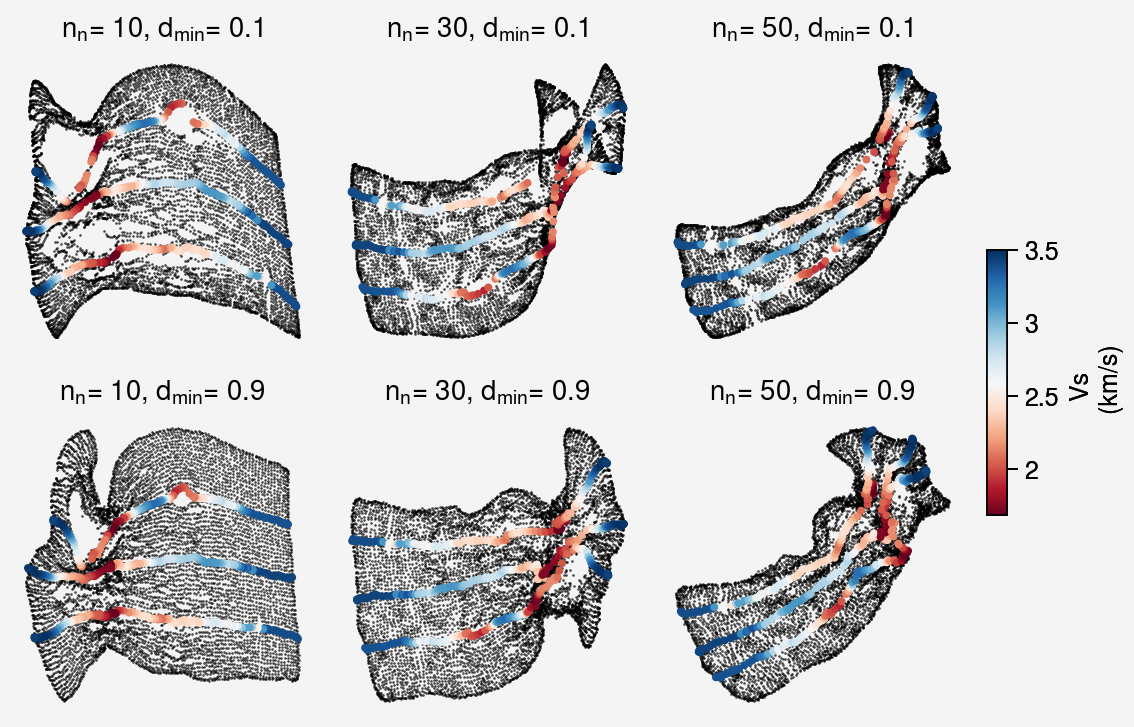

In [ ]:
fig = pplt.figure( sharey=False, sharex=False, refwidth=1.5)
axs = fig.subplots(ncols=3, nrows=2,)

for i, nn in enumerate(k_neighbors):
    for j, dd in enumerate(min_distances[::2]):

        im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][:, 0], 
            UMAP_SPACE_HYPERPAR[i][j][:, 1], c = 'k', cmap = 'RdBu', 
            s = 0.1, alpha = 0.75, rasterized=True)
        
        for k in vs_plotindex:
            im = axs[j, i].scatter(UMAP_SPACE_HYPERPAR[i][j][indxvs[:, k], 0], 
                UMAP_SPACE_HYPERPAR[i][j][indxvs[:, k], 1], 
                c = vs.reshape(-1)[indxvs[:, k]], cmap = 'RdBu',
                s = 5, alpha = 1, rasterized=True)
        
        axs[j, i].set_title('$n_{n}$' +f'= {nn}, ' +  '$d_{min}$'+ f'= {dd}')

        axs[j, i].spines['top'].set_visible(False)
        axs[j, i].spines['right'].set_visible(False)
        
        axs[1, i].set_xlabel('UMAP \n variable 1')
        axs[j, 0].set_ylabel('UMAP \n variable 2')
        axs[j, i].axis("off")
        
fig.colorbar(im, width = 0.1, shrink=0.4, label = 'Vs \n (km/s)')

fig.tight_layout()
fig.savefig(savepath + "UMAP_hyperparameters" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [ ]:
LOC_DIM_HYPERPAR = []
varaince_threshold = [0.45, 0.7, 0.9]

for i in (range(len(k_neighbors))):
    loc_dim_hyp = []
    for j in range(len(varaince_threshold)):
        loc_dim_hyp.append(calculate_local_dimension(UMAPS_MODEL_HYPERPAR[i][0], threshold = varaince_threshold[j]))
    
    LOC_DIM_HYPERPAR.append(loc_dim_hyp)
    
    print(f'UMAP for data {i}')
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:19<00:00, 408.93it/s]


UMAP for data 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [01:09<00:00, 111.50it/s]


UMAP for data 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [02:18<00:00, 56.27it/s]

UMAP for data 2


/tmp/ipykernel_3172938/4226339574.py:37: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python

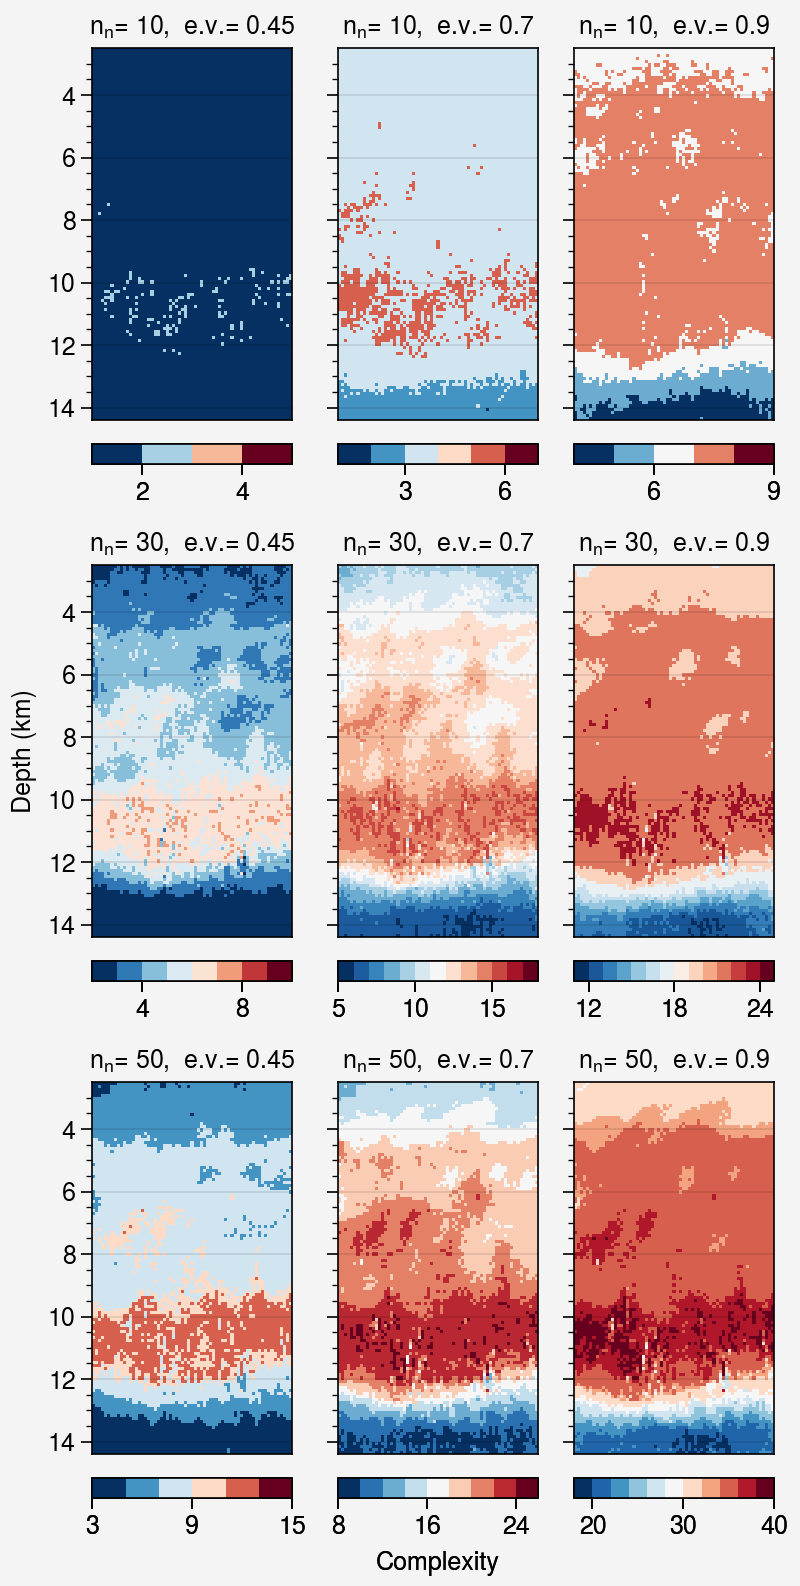

In [40]:
fig = pplt.figure(  sharey=True, sharex=True, refwidth=1.)
axs = fig.subplots(ncols=3, nrows=3,  order='F')

smp = [3, 5, 8]

for i, nn in enumerate(k_neighbors):
    for j, var in enumerate(varaince_threshold):

        locdim = LOC_DIM_HYPERPAR[i][j]
        ncl = np.max(locdim) - np.min(locdim) + 1
        levels = pplt.arange(np.min(locdim), np.max(locdim)+2, 1+i//2)
        cmap = pplt.Colormap('RdBu_r')
        if (j==1) and (i==2): 
            ttitle= 'Complexity' 
        else:
            ttitle=''

        im = axs[i, j].imshow( locdim.reshape(120, 65), 
                              rasterized = True,  cmap = cmap,
                             levels=levels, colorbar = 'b', colorbar_kw={'label': ttitle, "width" : 0.1},
                              extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()])

        axs[i, j].set_title('$n_{n}$' +f'= {nn}, ' +  ' e.v.'+ f'= {var}', fontsize = 9)
        axs[i, j].set_ylim(y_dist.max(), y_dist.min())
        axs[i, j].set_xlim(x_dist.min(), x_dist.max())
        
        axs[i, 0].set_ylabel('Depth (km)')
        
        # divider = make_axes_locatable(axs[i, j])
        # cax1 = divider.append_axes('bottom', size='5%', pad=0.1)
        # cbar = plt.colorbar(im, cax=cax1, orientation='horizontal', aspect = 1, ticks=np.arange(locdim.min(), locdim.max() + 1)[::1+ncl//5]+0)
        
        axs[i, j].set_xticks([])
        
            
            
fig.tight_layout()
fig.savefig(savepath + "UMAP_hyperparameters_dimensionality" + ".png", bbox_inches="tight", dpi=300, transparent=True)



In [41]:
threshold = 0.8
radii = 3


loc_dim_in_model = []

for dd in [scattering_coef_vs_norm, scattering_coef_hs_norm]:
    ld_md = calculate_local_dimensionality_in_model(dd, 
                                            vs.shape, radii = radii, 
                                            threshold = threshold)
    
    loc_dim_in_model.append(ld_md)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [02:31<00:00,  1.26s/it]


In [42]:
threshold = 0.8


entropy_in_model = []

for dd in [scattering_coef_vs_norm, scattering_coef_hs_norm]:
    ld_md = calculate_local_entropy_in_model(dd, 
                                            vs.shape, radii = radii, 
                                            )
    
    entropy_in_model.append(ld_md)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [02:10<00:00,  1.08s/it]


/tmp/ipykernel_3172938/668086205.py:18: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 7, 'vmax': 29}
  im1 = ax[i+1].imshow(loc_dim.reshape(120, 65),
/tmp/ipykernel_3172938/668086205.py:18: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 8, 'vmax': 28}
  im1 = ax[i+1].imshow(loc_dim.reshape(120, 65),
/tmp/ipykernel_3172938/668086205.py:41: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tr

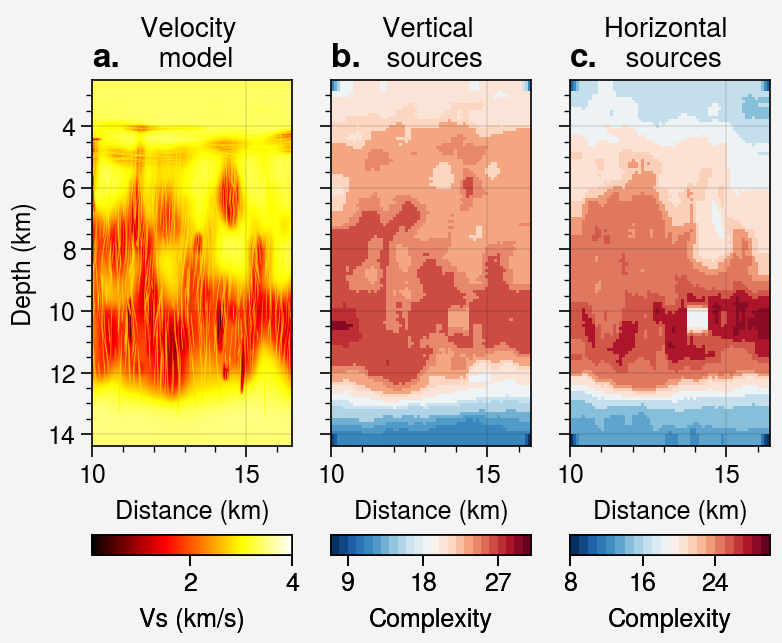

In [43]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
ax = fig.subplots(ncols=3, nrows=1)

im1 = ax[0].imshow(vs_hr, extent= [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap= 'hot', vmin = 0.1, vmax =4, 
                       rasterized= True, colorbar = 'b', colorbar_kw={'label':'Vs (km/s)', 'width':0.1})


ax[0].set_ylim(y_dist.max(), y_dist.min())
ax[0].set_ylabel('Depth (km)')
ax[0].set_xlabel('Distance (km)')


for i, loc_dim in enumerate(loc_dim_in_model):    
    
    levels = pplt.arange(np.min(loc_dim), np.max(loc_dim)+2, 1)

    im1 = ax[i+1].imshow(loc_dim.reshape(120, 65), 
                        cmap= 'RdBu_r', 
                        vmin= loc_dim.min(), 
                        vmax= loc_dim.max(), 
                        extent= [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
                        aspect= 'auto', 
                        rasterized= True,
                        colorbar= 'b',
                        colorbar_kw= {'label':'Complexity', 'width':0.1}, 
                        levels= levels)

    ax[i+1].set_ylim(y_dist.max(), y_dist.min())
    ax[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    ax[i+1].set_xlabel('Distance (km)')
    #cbar.set_label('Complexity index')

for i in range(len(ax)):
    ax[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

[ax[i].set_title(f) for i, f in enumerate(['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources'])]

fig.tight_layout()
fig.savefig(savepath + "LOCAL_DIMENSIONALITY_in_model" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



/tmp/ipykernel_3172938/2199529926.py:36: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python

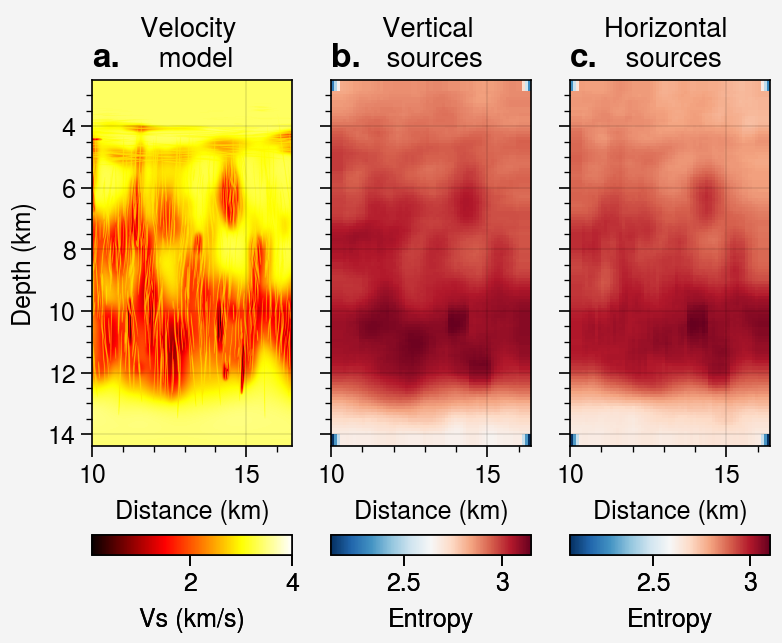

In [55]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
ax = fig.subplots(ncols=3, nrows=1)

im1 = ax[0].imshow(vs_hr, extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
                       cmap = 'hot', vmin = 0.1, vmax =4, 
                       rasterized = True, colorbar = 'b', colorbar_kw={'label':'Vs (km/s)', 'width':0.1})


ax[0].set_ylim(y_dist.max(), y_dist.min())
ax[0].set_ylabel('Depth (km)')
ax[0].set_xlabel('Distance (km)')


for i, loc_dim in enumerate(entropy_in_model): 
    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = ax[i+1].imshow(loc_dim.reshape(120, 65), 
                        cmap = 'RdBu_r', 
                        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
                        aspect = 'auto', 
                        rasterized = True,
                        colorbar = 'b',
                        colorbar_kw={'label':'Entropy', 'width':0.1})

    ax[i+1].set_ylim(y_dist.max(), y_dist.min())
    ax[i+1].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    ax[i+1].set_xlabel('Distance (km)')
    #cbar.set_label('Complexity index')

for i in range(len(ax)):
    ax[i].set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

[ax[i].set_title(f) for i, f in enumerate(['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources'])]

fig.tight_layout()
fig.savefig(savepath + "entropy_in_model" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



In [45]:

LOCAL_ENTROPY_HYPER = []

for i in (range(len(k_neighbors))):
    LOCAL_ENTROPY_HYPER.append(
        calculate_entropy_in_umap(UMAPS_MODEL_HYPERPAR[i][0], 
                                  scattering_coef_vs_norm))
    
    print(f'UMAP for data {i}')
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [00:22<00:00, 345.51it/s]


UMAP for data 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [01:06<00:00, 117.63it/s]


UMAP for data 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [02:26<00:00, 53.39it/s]

UMAP for data 2


/tmp/ipykernel_3172938/1336200990.py:30: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python

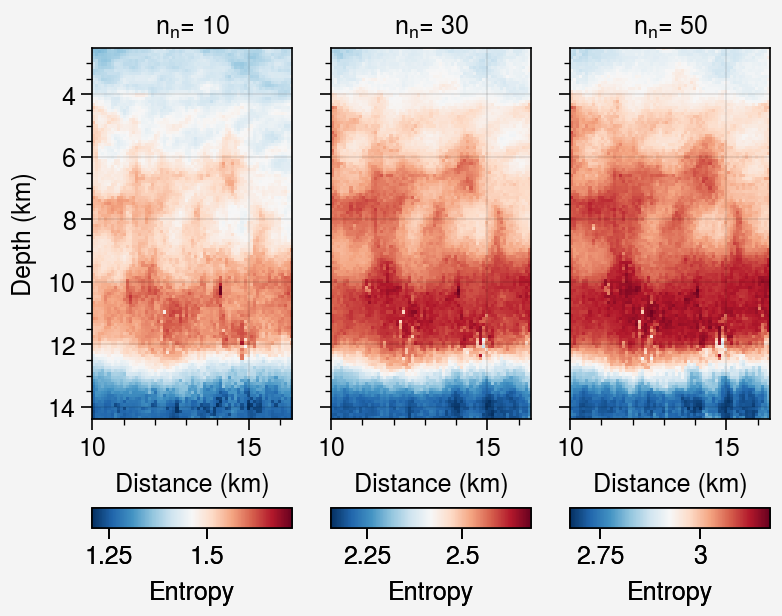

In [56]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
axs = fig.subplots(ncols=3, nrows=1)

for i, nn in enumerate(k_neighbors):
    locdim = LOCAL_ENTROPY_HYPER[i]
    
    cmap = 'RdBu' # plt.get_cmap('RdBu_r')
    
    #im1 = axs[i+1].pcolor(x_dist, y_dist, loc_dim.reshape(120, 65), cmap = cmap, vmin = loc_dim.min(), vmax = loc_dim.max(), edgecolors='k', linewidths=0.05, rasterized = True)
    im1 = axs[i].imshow(locdim.reshape(120, 65), cmap = 'RdBu_r', 
                        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], 
                        rasterized = True, colorbar = 'b', 
                        colorbar_kw = {'label': 'Entropy', 'width': 0.1})
    
    axs[i].set_ylim(y_dist.max(), y_dist.min())
    axs[i].set_xlim(x_dist.min(), x_dist.max())

    #ax[1].set_ylim(dim.min()-1, dim.max()+1)
    axs[i].set_xlabel('Distance (km)')
    # divider = make_axes_locatable(axs[i+1])
    # cax1 = divider.append_axes('bottom', size='5%', pad=0.55, )
    # cbar = plt.colorbar(im1, cax=cax1, orientation='horizontal')
    # cbar.set_label('Entropy')
    
    axs[i].set_title('$n_{n}$' +f'= {nn}', fontsize = 9)

axs[0].set_ylabel('Depth (km)')
#[axs[i].set_title(f) for i, f in enumerate(['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources'])]

fig.tight_layout()
fig.savefig(savepath + "UMAP_LOCAL_ENTROLPY_hyperpar" + ".png", bbox_inches="tight", dpi=300, transparent=True,)

    


import numpy as np
from scipy.cluster.hierarchy import fcluster, linkage

def between_cluster_variability(data, linkage_matrix, num_clusters):
    """
    Calculate the between-cluster variability (between-cluster sum of squares).
    
    Parameters:
    - data: array-like, original dataset (each row represents a point).
    - linkage_matrix: array-like, linkage matrix from hierarchical clustering.
    - num_clusters: int, the number of clusters to form.
    
    Returns:
    - between_variability: The between-cluster variability.
    """
    # Calculate the overall mean of the data
    overall_mean = np.mean(data, axis=0)
    
    # Obtain flat cluster assignments from the linkage matrix
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Initialize between-cluster variability
    between_variability = 0
    
    # Calculate between-cluster variability
    for cluster_id in np.unique(cluster_labels):
        # Get data points belonging to the current cluster
        cluster_points = data[cluster_labels == cluster_id]
        
        # Compute the centroid of the cluster
        cluster_centroid = cluster_points.mean(axis=0)
        
        # Compute squared distance from the cluster centroid to the overall mean
        squared_distance_to_mean = np.sum((cluster_centroid - overall_mean) ** 2)
        
        # Weight by the number of points in the cluster
        between_variability += len(cluster_points) * squared_distance_to_mean
    
    return between_variability

# Example usage
# data = np.random.rand(100, 2)  # Example data
# linkage_matrix = linkage(data, method='ward')
# between_variability = between_cluster_variability(data, linkage_matrix, num_clusters=5)
# print("Between-cluster variability:", between_variability)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def deeper_dendrogram(linkage_matrix, cluster_id, max_depth=10):
    """
    Generate a deeper dendrogram for a specified cluster.
    
    Parameters:
    - linkage_matrix: array-like, linkage matrix from scipy's hierarchical clustering.
    - cluster_id: int, ID of the cluster for which to generate a deeper dendrogram.
    - max_depth: int, the maximum depth of clustering to display in the dendrogram.
    
    Returns:
    - None, but plots the dendrogram.
    """
    # Extract all clusters at the max depth level from the linkage matrix
    clusters = fcluster(linkage_matrix, t=max_depth, criterion='maxclust')
    
    # Isolate data points belonging to the specified cluster_id
    subcluster_indices = np.where(clusters == cluster_id)[0]
    
    if len(subcluster_indices) < 2:
        print("The specified cluster is too small to generate a deeper dendrogram.")
        return

    # Create a sub-linkage matrix only for the points in the subcluster
    subcluster_data = linkage_matrix[subcluster_indices]
    
    # Plot dendrogram of the deeper subcluster
    plt.figure(figsize=(10, 7))
    dendrogram(subcluster_data)
    plt.title(f"Deeper Dendrogram for Cluster {cluster_id}")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

# Example usage
# Assume linkage_matrix is obtained from `linkage(data, method='ward')`
# deeper_dendrogram(linkage_matrix, cluster_id=1, max_depth=10)

import numpy as np
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster, linkage

def within_cluster_variability(data, linkage_matrix, num_clusters):
    """
    Calculate within-cluster variability for each cluster.
    
    Parameters:
    - data: array-like, original dataset (each row represents a point).
    - linkage_matrix: array-like, linkage matrix from hierarchical clustering.
    - num_clusters: int, the number of clusters to form.
    
    Returns:
    - variability_dict: Dictionary where keys are cluster IDs and values are within-cluster variability.
    """
    # Obtain flat cluster assignments from the linkage matrix
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Initialize dictionary to store variability for each cluster
    variability_dict = {}
    
    # Calculate within-cluster variability for each cluster
    for cluster_id in np.unique(cluster_labels):
        # Get data points belonging to the current cluster
        cluster_points = data[cluster_labels == cluster_id]
        
        # Compute the centroid of the cluster
        centroid = cluster_points.mean(axis=0)
        
        # Calculate squared distances to the centroid and sum them up
        squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
        within_variability = np.sum(squared_distances)
        
        # Store the within-cluster variability for the current cluster
        variability_dict[cluster_id] = within_variability
    
    return variability_dict

# Example usage
# data = np.random.rand(100, 2)  # Example data
# linkage_matrix = linkage(data, method='ward')
# within_variability = within_cluster_variability(data, linkage_matrix, num_clusters=5)
# print("Within-cluster variability:", within_variability)


def hierarchical_cluster_explanation(data, num_clusters, method='ward'):
    """
    Perform hierarchical clustering and provide explanations for each cluster.
    
    Parameters:
    - data: DataFrame, input data with each row as a data point and columns as features.
    - num_clusters: int, the number of clusters to form.
    - method: str, linkage method for hierarchical clustering (e.g., 'ward', 'single', 'complete', 'average').
    
    Returns:
    - cluster_summary: DataFrame summarizing the characteristics of each cluster.
    - cluster_importance: DataFrame showing the importance (Z-scores) of each feature in each cluster.
    """
    # Perform hierarchical clustering
    linkage_matrix = linkage(data, method=method)
    
    # Assign cluster labels
    data['cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Cluster Summary: Calculate descriptive statistics for each cluster
    cluster_summary = data.groupby('cluster').agg(['mean', 'std', 'min', 'max']).T
    
    # Cluster Importance: Calculate feature-wise Z-scores for each cluster to gauge feature importance
    cluster_means = data.groupby('cluster').mean()
    overall_mean = data.drop(columns=['cluster']).mean()
    overall_std = data.drop(columns=['cluster']).std()
    
    cluster_importance = (cluster_means - overall_mean) / overall_std
    cluster_importance = cluster_importance.T  # Transpose for readability
    
    # Rename columns and indexes for clarity
    cluster_importance.columns = [f'Cluster_{i}_importance' for i in range(1, num_clusters + 1)]
    cluster_summary.columns = [f'Cluster_{i}_{stat}' for i in range(1, num_clusters + 1) for stat in ['mean', 'std', 'min', 'max']]
    
    return cluster_summary, cluster_importance

# Example usage
# data = pd.DataFrame(np.random.rand(100, 4), columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4'])
# cluster_summary, cluster_importance = hierarchical_cluster_explanation(data, num_clusters=3)
# print("Cluster Summary:\n", cluster_summary)
# print("Cluster Importance:\n", cluster_importance)